# Dataset loading

Download the datasets in TFRecord format.

In [ ]:
!gdown https://drive.google.com/uc?id=1XPaSRHsGHGkLieZnR6cU8-Bwg6_1kCTj
!gdown https://drive.google.com/uc?id=1wD3vKqKEFh6OfrfLNtOENF-lbe4auQDb

Define paths.

In [ ]:
train_tf_records_path = '/content/train_tfrecords0.record'
test_tf_records_path = '/content/test_tfrecords0.record'

# Dataset decoding
Define a set of decoding functions.

In [ ]:
import tensorflow as tf
import numpy as np

def load_tf_records(filepath):
    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    return dataset

def tf_records_file_features_description():
    image_feature_description = {
        
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([],tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
        'label/P': tf.io.FixedLenFeature([], tf.float32),
        'label/K': tf.io.FixedLenFeature([], tf.float32),
        'label/Mg': tf.io.FixedLenFeature([], tf.float32),
        'label/Ph': tf.io.FixedLenFeature([], tf.float32),
    }
    return image_feature_description

def decode_dataset(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description())

    image=features['image']
    height=features['image/height']
    width=features['image/width']
    image=tf.io.decode_raw(image,tf.int16)
    image=tf.reshape(image,[height,width,150])
    filename=features['image/filename']

    P=features['label/P']
    K=features['label/K']
    Mg=features['label/Mg']
    Ph=features['label/Ph']

    height=features['image/height']
    width=features['image/width']

    label=[P,K,Mg,Ph]

    return image, label, height, width

def load_tf_records_test(filepath):
    filenames = tf.io.gfile.glob(filepath)
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=tf.data.experimental.AUTOTUNE)
    return dataset

def tf_records_file_features_description_test():
    image_feature_description = {
        
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image': tf.io.FixedLenFeature([],tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }

    return image_feature_description

def decode_dataset_test(example_proto):
    features=tf.io.parse_single_example(example_proto, tf_records_file_features_description_test())

    image=features['image']
    height=features['image/height']
    width=features['image/width']
    image=tf.io.decode_raw(image,tf.int16)
    image=tf.reshape(image,[height,width,150])
    filename=features['image/filename']

    height=features['image/height']
    width=features['image/width']

    return image, height, width

#Dataset analysis
This section performs some basic analysis on the dataset which drove the NN design.

**It is not necessary to run this section for training the model.**

Load train and test datasets.

In [ ]:
train_data=load_tf_records(train_tf_records_path).map(decode_dataset)
test_data=load_tf_records_test(test_tf_records_path).map(decode_dataset_test)

In [ ]:
# Define some useful functions

def max_train(dataset):                      #Find maximum reflectance in train set
    max = 0
    for image, label, height, width in dataset:
        max_reflectance = np.amax(image)
        if max_reflectance > max:
            max = max_reflectance
    return(max)

def min_train(dataset, min):                 #Find minimum reflectance in train set
    for image, label, height, width in dataset:
        min_reflectance = np.amin(image)
        if min_reflectance < min:
            min = min_reflectance
    return(min)

def max_test(dataset):                       #Find maximum reflectance in test set
    max = 0
    for image, height, width in dataset:
        max_reflectance = np.amax(image)
        if max_reflectance > max:
            max = max_reflectance
    return(max)

def min_test(dataset,min):                   #Find minimum reflectance in test set
    for image, height, width in dataset:
        min_reflectance = np.amin(image)
        if min_reflectance < min:
            min = min_reflectance
    return(min)

In [ ]:
# Calculate maximum and mimimum reflectance values both for train and test data

max_reflectance_train = max_train(train_data)
min_reflectance_train = min_train(train_data, max_reflectance_train)
print('Max reflectance in train:', max_reflectance_train)
print('Min reflectance in train:', min_reflectance_train)

max_reflectance_test = max_test(test_data)
min_reflectance_test = min_test(test_data, max_reflectance_test)
print('Max reflectance in test:', max_reflectance_test)
print('Min reflectance in test:', min_reflectance_test)

max_reflectance_overall = np.amax([max_reflectance_test, max_reflectance_train])
print('Overall max reflectance:', max_reflectance_overall)

Max reflectance in train: 5419
Min reflectance in train: -3
Max reflectance in test: 6315
Min reflectance in test: -13
Overall max reflectance: 6315


In [ ]:
# Calculate maximum height and width on the whole dataset

shape_data_train = np.array(list(train_data.map(lambda image, label, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims_train, w_dims_train = np.hsplit(shape_data_train, 2)

shape_data_test = np.array(list(test_data.map(lambda image, height, width: tf.shape(image)[0:2]).as_numpy_iterator()))
h_dims_test, w_dims_test = np.hsplit(shape_data_test, 2)

max_height_train = np.amax(h_dims_train)
max_width_train = np.amax(w_dims_train)
print('Max height train:', max_height_train)
print('Max width train:', max_width_train)

max_height_test = np.amax(h_dims_test)
max_width_test = np.amax(w_dims_test)
print('Max height test:', max_height_test)
print('Max width test:', max_width_test)

max_height = np.amax([max_height_test, max_height_train])
max_width = np.amax([max_width_test, max_width_train])
print('Max height:', max_height)
print('Max width:', max_width)

Max height train: 268
Max width train: 284
Max height test: 229
Max width test: 273
Max height: 268
Max width: 284


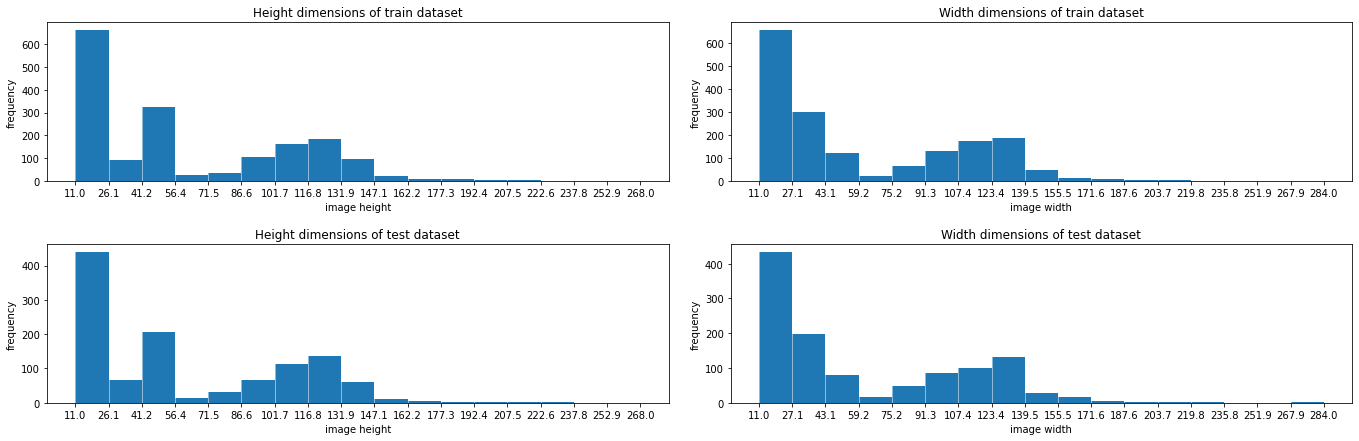

In [ ]:
# Show image size distribution

import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(25,7))

plt.subplots_adjust(wspace=0.1, hspace=0.4, right=0.85)

n_h, bins_h, patches_h = axs[0,0].hist(h_dims_train, bins='auto')
axs[0,0].set_title('Height dimensions of train dataset')
axs[0,0].set_xlabel('image height')
axs[0,0].set_ylabel('frequency')
axs[0,0].set_xticks(bins_h)
axs[0,0].grid(color='white', lw = 0.5, axis='x')

n_w, bins_w, patches_w = axs[0,1].hist(w_dims_train, bins='auto')
axs[0,1].set_title('Width dimensions of train dataset')
axs[0,1].set_xlabel('image width')
axs[0,1].set_ylabel('frequency')
axs[0,1].set_xticks(bins_w)
axs[0,1].grid(color='white', lw = 0.5, axis='x')

n_h, bins_h, patches_h = axs[1,0].hist(h_dims_test, bins=bins_h)
axs[1,0].set_title('Height dimensions of test dataset')
axs[1,0].set_xlabel('image height')
axs[1,0].set_ylabel('frequency')
axs[1,0].set_xticks(bins_h)
axs[1,0].grid(color='white', lw = 0.5, axis='x')

n_w, bins_w, patches_w = axs[1,1].hist(w_dims_test, bins=bins_w)
axs[1,1].set_title('Width dimensions of test dataset')
axs[1,1].set_xlabel('image width')
axs[1,1].set_ylabel('frequency')
axs[1,1].set_xticks(bins_w)
axs[1,1].grid(color='white', lw = 0.5, axis='x')

plt.show()

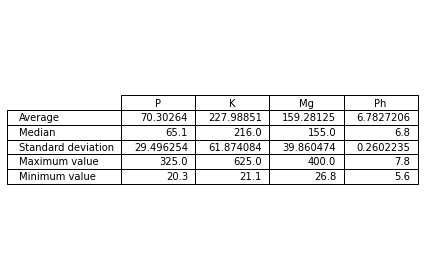

In [ ]:
# Calculate average, median and standard deviation for ground truth values

import pandas as pd

gt_data = np.array(list((train_data.map(lambda image, label, height, width: label)).as_numpy_iterator()))

gt_avg = np.mean(gt_data, axis=0)
gt_median = np.median(gt_data, axis=0)
gt_std = np.std(gt_data, axis=0)
gt_max = np.amax(gt_data, axis=0)
gt_min = np.amin(gt_data, axis=0)
gt_stats = np.append([gt_avg], [gt_median, gt_std, gt_max,gt_min], axis=0)

fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df=pd.DataFrame(gt_stats, columns=['P', 'K', 'Mg', 'Ph'],)

ax.table(cellText=df.values, colLabels=df.columns, rowLabels=['Average', 'Median', 'Standard deviation', 'Maximum value','Minimum value'], loc='center')

fig.tight_layout()

plt.show()

In [ ]:
# Find baseline mse in order to later define evaluation metrics

mse_baseline = np.mean((gt_data-gt_avg)**2, axis=0)
print(mse_baseline)

[8.7002899e+02 3.8284023e+03 1.5888574e+03 6.7716271e-02]


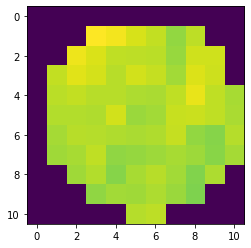

[ 45.1 188.  179.    7.2]


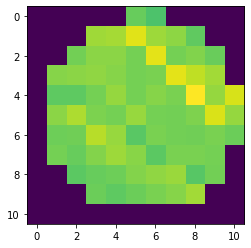

[ 44.8 205.  188.    7. ]


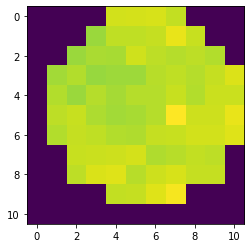

[ 44.4 207.  145.    6.8]


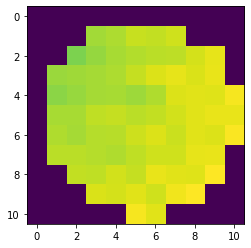

[ 46.5 204.  143.    6.8]


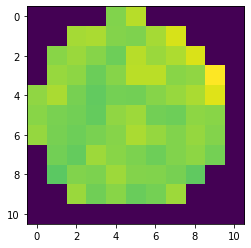

[ 52.  212.  167.    6.7]


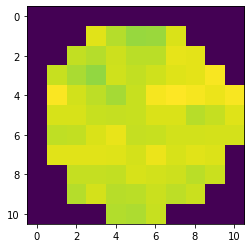

[ 50.1 206.  184.    6.8]


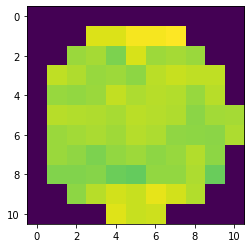

[ 66.5 194.  150.    7. ]


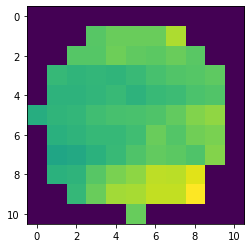

[ 67.4 199.  149.    7.1]


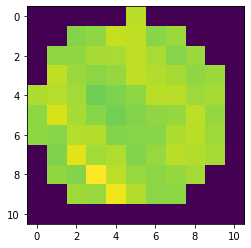

[ 76.2 202.  151.    7.1]


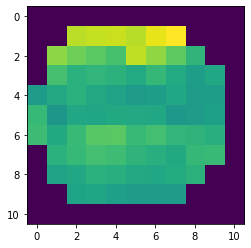

[ 74.3 219.  164.    7.2]


In [ ]:
# Print some entries from train set

for a, b, height, width in train_data.take(10):
  plt.imshow(a[:,:,1].numpy())
  plt.show()
  print(b.numpy())


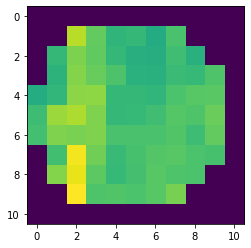

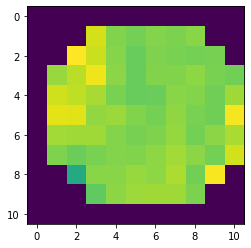

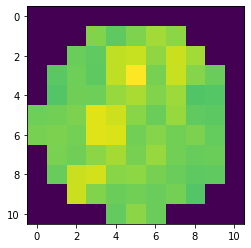

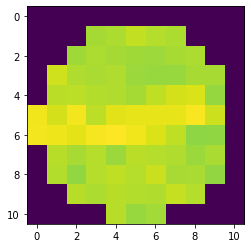

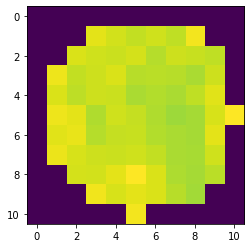

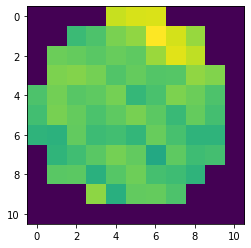

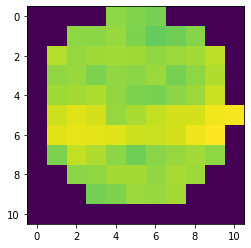

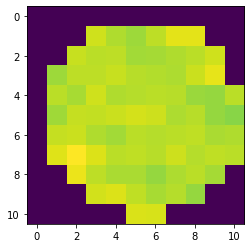

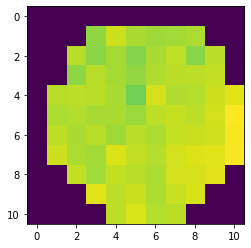

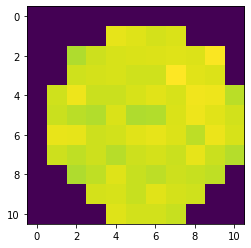

In [ ]:
# Print some entries from test set

for a, height, width in test_data.take(10):
    plt.imshow(a[:,:,1].numpy())
    plt.show()

# Dataset preprocessing and model training

Import libraries and set random seeds.

In [ ]:
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import os
import random as rn
import numpy as np
import tensorflow as tf

rn.seed(2)
np.random.seed(3)
tf.random.set_seed(1)

AUTO = tf.data.AUTOTUNE 

Define preprocessing values.

In [ ]:
max_reflectance_overall = 6315

max_height = 268
max_width = 284

num_train_images = 1732
num_test_images = 1153

max_gt_values = [325, 625, 400, 14]

mse_baseline = [870.02899169921875, 3828.40234375, 1588.857421875, 0.0677162706851959228515625]


Define normalization and augmentation functions for train set.

In [ ]:
target_image_size = 32

def normalize_train(image,label, height, width, max_reflectance_overall, max_gt_values):    #Function to normalize the train dataset
    image = tf.cast(image,tf.float32)
    image = image/(max_reflectance_overall)
    label /= max_gt_values

    return image, label, height, width

def make_horizontal_patch_train(patch, nx):    #Function that repeats a patch horizontally with random flips until the target width is reached, the result is a horizontal band
    hor_patch = tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=72), seed=64)
    i=0

    def cond(hor_patch, patch, i, nx):
        return tf.less(i, nx-1)
    def body(hor_patch, patch, i, nx):
        hor_patch = tf.concat([hor_patch, tf.image.random_flip_left_right(tf.image.random_flip_up_down(patch, seed=49), seed=95)], 1)
        i+=1
        return hor_patch, patch, i, nx

    hor_patch, _, _, _ = tf.while_loop(cond, body, [hor_patch, patch, i, nx])

    return hor_patch

def image_repetition_train(image, height, width):    #Function that repeats small images applying random flips to create a bigger image
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    patch = image
    image = make_horizontal_patch_train(patch, nx)
    i=0

    def cond(image, patch, i, ny):
        return tf.less(i, ny-1)
    def body(image, patch, i, ny):
        image = tf.concat([image, make_horizontal_patch_train(patch, nx)], 0)
        i+=1
        return image, patch, i, ny
    
    image, _, _, _= tf.while_loop(cond, body, [image, patch, i, ny])

    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_train(image, label, height, width):    #Function to resize images
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_train(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))
    image=add_gauss_noise(image)

    index=tf.random.uniform(shape=[],maxval=4,dtype=tf.dtypes.int32,seed=32)
    
    image=tf.cond(tf.equal(index,1),lambda: tf.image.flip_left_right(image), lambda: image)

    image=tf.cond(tf.equal(index,2),lambda: tf.image.flip_up_down(image), lambda: image)

    image=tf.cond(tf.equal(index,3),lambda: tf.image.flip_left_right(tf.image.flip_up_down(image)), lambda: image)

    return image, label

def add_gauss_noise(image): #Function to add Gaussian noise
      
    mean = 0
    std = 0.05
      
    gauss = tf.random.normal([target_image_size,target_image_size,150], mean,std,seed=910)

    noisy = image + gauss
    return noisy

Training setup.

In [ ]:
epochs = 300
batch_size = 32
steps_per_epoch = num_train_images//batch_size

Dataset mapping (tf.data.Dataset API).

In [ ]:
#Train
ds = load_tf_records(train_tf_records_path).map(decode_dataset, num_parallel_calls=AUTO)
ds = ds.shuffle(num_train_images, seed=1866)

train_data = ds.take(1728)
train_data = train_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, max_reflectance_overall, max_gt_values), num_parallel_calls=AUTO).cache()    #normalize train dataset
train_data = train_data.shuffle(num_train_images, seed=1866)    #shuffle train dataset
train_data = train_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)    #pad test dataset
train_data = train_data.batch(batch_size=batch_size, drop_remainder=True)    #batch train dataset
train_data = train_data.prefetch(AUTO)    #prefetch train dataset

#Validation
val_data = ds.skip(1728)    #create a small validation dataset from the last elements of the train dataset that are discarded during batching
val_data =val_data.map(lambda image, label, height, width: normalize_train(image, label, height, width, max_reflectance_overall, max_gt_values), num_parallel_calls=AUTO).cache()    #normalize validation dataset 
val_data = val_data.map(lambda image, label, height, width: pad_with_patches_train(image, label, height, width), num_parallel_calls=AUTO)    #pad validation dataset
val_data = val_data.repeat(2)
val_data = val_data.batch(batch_size=8, drop_remainder=False)    #batch validation dataset
val_data = val_data.prefetch(AUTO)    #prefetch validation dataset

Print some bands from a training image.

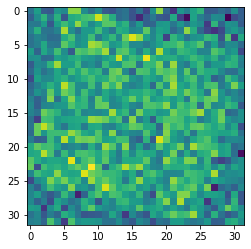

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


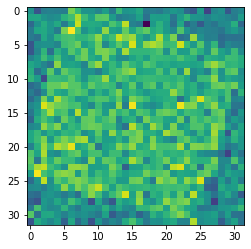

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


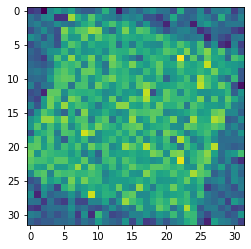

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


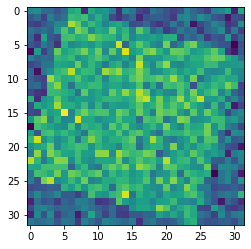

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


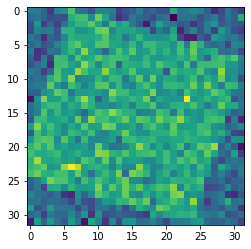

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


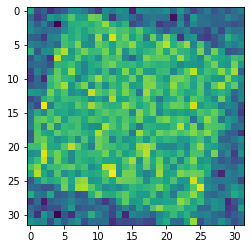

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


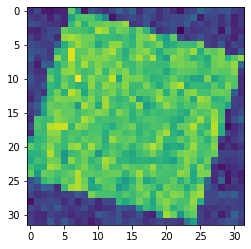

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


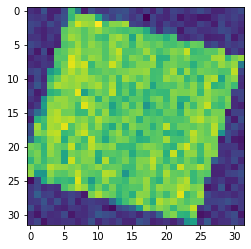

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


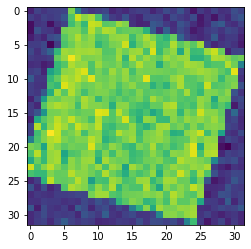

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


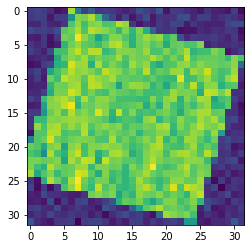

tf.Tensor([0.16830769 0.3008     0.4225     0.47142857], shape=(4,), dtype=float32)


In [ ]:
for image, label in train_data.unbatch().take(1):
    for i in range(10):
        plt.imshow(image[:,:,i*14])
        plt.show()
        print(label)
    

# Build and train NN model
EfficientNet-Lite: the following cell is adapted from https://github.com/sebastian-sz/efficientnet-lite-keras, distributed under Apache License 2.0. We defined a new "EfficientNetLiteB0mod" setting width and depth to 0.5.

In [ ]:
import copy
import math

import tensorflow as tf
from tensorflow.keras import layers

if tf.__version__ < "2.8":  # Keras has been moved to separate repository
    from tensorflow.python.keras.applications import imagenet_utils
else:
    from keras.applications import imagenet_utils

from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io

DEFAULT_BLOCKS_ARGS = [
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 32,
        "filters_out": 16,
        "expand_ratio": 1,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 3,
        "repeats": 2,
        "filters_in": 16,
        "filters_out": 24,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 2,
        "filters_in": 24,
        "filters_out": 40,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 3,
        "filters_in": 40,
        "filters_out": 80,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 5,
        "repeats": 3,
        "filters_in": 80,
        "filters_out": 112,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
    {
        "kernel_size": 5,
        "repeats": 4,
        "filters_in": 112,
        "filters_out": 192,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 2,
    },
    {
        "kernel_size": 3,
        "repeats": 1,
        "filters_in": 192,
        "filters_out": 320,
        "expand_ratio": 6,
        "id_skip": True,
        "strides": 1,
    },
]

CONV_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 2.0, "mode": "fan_out", "distribution": "truncated_normal"},
}

DENSE_KERNEL_INITIALIZER = {
    "class_name": "VarianceScaling",
    "config": {"scale": 1.0 / 3.0, "mode": "fan_out", "distribution": "uniform"},
}

WEIGHTS_BASE_URL = (
    "https://github.com/sebastian-sz/efficientnet-lite-keras/releases/download/v1.0/"
)
WEIGHTS_HASHES = {
    "efficientnet_lite_b0.h5": "8236b3edc4bd9019865ffd8290cf0b05",
    "efficientnet_lite_b0_notop.h5": "d7a91a3c0e7f0bdffe67f599ebe511cd",
    "efficientnet_lite_b1.h5": "8684671aebaf23b7fb03a0e10fbea162",
    "efficientnet_lite_b1_notop.h5": "9fece5f941068bf189913cd5b42439bf",
    "efficientnet_lite_b2.h5": "e3c7128846d3297734ec7465cb171989",
    "efficientnet_lite_b2_notop.h5": "d0b7d56925cc4b82e30a45570766b32e",
    "efficientnet_lite_b3.h5": "f6a5df9c63310630a5a7f9bcc45c9598",
    "efficientnet_lite_b3_notop.h5": "7ae45c1c6cb1d2ba5193d131984a2225",
    "efficientnet_lite_b4.h5": "25b9276e711f82443523df227aa32cad",
    "efficientnet_lite_b4_notop.h5": "8939585df7b434869381f7786dc60290",
}


def EfficientNetLite(
    width_coefficient,
    depth_coefficient,
    default_size,
    dropout_rate=0.2,
    drop_connect_rate=0.2,
    depth_divisor=8,
    blocks_args="default",
    model_name="efficientnet",
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
):
    """
    Instantiate the EfficientNet architecture using given scaling coefficients.

    Args:
        width_coefficient: float, scaling coefficient for network width.
        depth_coefficient: float, scaling coefficient for network depth.
        default_size: integer, default input image size.
        dropout_rate: float, dropout rate before final classifier layer.
        drop_connect_rate: float, dropout rate at skip connections.
        depth_divisor:  integer, a unit of network width.
        blocks_args: list of dicts, parameters to construct block modules.
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: 'imagenet' or path to weights file.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False.
            It should have exactly 3 inputs channels.
        pooling: when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
        classifier_activation: A `str` or callable.
            The activation function to use on the "top" layer. Ignored unless
            `include_top=True`. Set`classifier_activation=None`
            to return the logits of the "top" layer.

    Returns:
        A `keras.Model` instance.

    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
        ValueError: if `classifier_activation` is not `softmax` or `None` when
            using a pretrained top layer.
    """
    if blocks_args == "default":
        blocks_args = DEFAULT_BLOCKS_ARGS

    if not (weights in {"imagenet", None} or file_io.file_exists_v2(weights)):
        raise ValueError(
            "The `weights` argument should be either "
            "`None` (random initialization), `imagenet` "
            "(pre-training on ImageNet), "
            "or the path to the weights file to be loaded."
        )

    if weights == "imagenet" and include_top and classes != 1000:
        raise ValueError(
            'If using `weights` as `"imagenet"` with `include_top`'
            " as true, `classes` should be 1000"
        )

    # Determine proper input shape
    input_shape = imagenet_utils.obtain_input_shape(
        input_shape,
        default_size=default_size,
        min_size=32,
        data_format=backend.image_data_format(),
        require_flatten=include_top,
        weights=weights,
    )
    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1

    def round_filters(filters, divisor=depth_divisor):
        """Round number of filters based on depth multiplier."""
        filters *= width_coefficient
        new_filters = max(divisor, int(filters + divisor / 2) // divisor * divisor)
        # Make sure that round down does not go down by more than 10%.
        if new_filters < 0.9 * filters:
            new_filters += divisor
        return int(new_filters)

    def round_repeats(repeats):
        """Round number of repeats based on depth multiplier."""
        return int(math.ceil(depth_coefficient * repeats))

    # Build stem
    x = img_input

    x = layers.ZeroPadding2D(
        padding=imagenet_utils.correct_pad(x, 3), name="stem_conv_pad"
    )(x)
    x = layers.Conv2D(
        32,
        3,
        strides=2,
        padding="valid",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="stem_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="stem_bn")(x)
    x = layers.ReLU(max_value=6, name="stem_activation")(x)

    # Build blocks
    blocks_args = copy.deepcopy(blocks_args)
    b = 0
    blocks = float(sum(args["repeats"] for args in blocks_args))

    for (i, args) in enumerate(blocks_args):
        assert args["repeats"] > 0
        # Update block input and output filters based on depth multiplier.
        args["filters_in"] = round_filters(args["filters_in"])
        args["filters_out"] = round_filters(args["filters_out"])

        if i == 0 or i == (len(blocks_args) - 1):
            repeats = args.pop("repeats")
        else:
            repeats = round_repeats(args.pop("repeats"))

        for j in range(repeats):
            # The first block needs to take care of stride and filter size increase.
            if j > 0:
                args["strides"] = 1
                args["filters_in"] = args["filters_out"]
            x = block(
                x,
                drop_connect_rate * b / blocks,
                name="block{}{}_".format(i + 1, chr(j + 97)),
                **args,
            )

            b += 1
    # Build top
    x = layers.Conv2D(
        1280,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name="top_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name="top_bn")(x)
    x = layers.ReLU(max_value=6, name="top_activation")(x)

    if include_top:
        x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        if dropout_rate > 0:
            x = layers.Dropout(dropout_rate, name="top_dropout")(x)
        imagenet_utils.validate_activation(classifier_activation, weights)
        x = layers.Dense(
            classes,
            activation=classifier_activation,
            kernel_initializer=DENSE_KERNEL_INITIALIZER,
            name="predictions",
        )(x)
    else:
        if pooling == "avg":
            x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
        elif pooling == "max":
            x = layers.GlobalMaxPooling2D(name="max_pool")(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = layer_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = tf.keras.Model(inputs, x, name=model_name)

    # Load weights.
    if weights == "imagenet":
        model_variant = "efficientnet_lite_b" + model_name[-1]

        if not include_top:
            model_variant += "_notop"

        filename = f"{model_variant}.h5"
        download_url = WEIGHTS_BASE_URL + filename
        weights_path = tf.keras.utils.get_file(
            fname=filename,
            origin=download_url,
            cache_subdir="models",
            file_hash=WEIGHTS_HASHES[filename],
        )
        model.load_weights(weights_path)

    elif weights is not None:
        model.load_weights(weights)

    return model


def block(
    inputs,
    drop_rate=0.0,
    name="",
    filters_in=32,
    filters_out=16,
    kernel_size=3,
    strides=1,
    expand_ratio=1,
    id_skip=True,
):
    """
    Create an inverted residual block.

    Args:
        inputs: input tensor.
        drop_rate: float between 0 and 1, fraction of the input units to drop.
        name: string, block label.
        filters_in: integer, the number of input filters.
        filters_out: integer, the number of output filters.
        kernel_size: integer, the dimension of the convolution window.
        strides: integer, the stride of the convolution.
        expand_ratio: integer, scaling coefficient for the input filters.
        id_skip: boolean.

    Returns:
        output tensor for the block.
    """
    bn_axis = 3 if backend.image_data_format() == "channels_last" else 1
    # Expansion phase
    filters = filters_in * expand_ratio
    if expand_ratio != 1:
        x = layers.Conv2D(
            filters,
            1,
            padding="same",
            use_bias=False,
            kernel_initializer=CONV_KERNEL_INITIALIZER,
            name=name + "expand_conv",
        )(inputs)
        x = layers.BatchNormalization(axis=bn_axis, name=name + "expand_bn")(x)
        x = layers.ReLU(max_value=6, name=name + "expand_activation")(x)
    else:
        x = inputs

    # Depthwise Convolution
    if strides == 2:
        x = layers.ZeroPadding2D(
            padding=imagenet_utils.correct_pad(x, kernel_size), name=name + "dwconv_pad"
        )(x)
        conv_pad = "valid"
    else:
        conv_pad = "same"
    x = layers.DepthwiseConv2D(
        kernel_size,
        strides=strides,
        padding=conv_pad,
        use_bias=False,
        depthwise_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "dwconv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "bn")(x)
    x = layers.ReLU(max_value=6, name=name + "activation")(x)

    # Skip SE

    # Output phase
    x = layers.Conv2D(
        filters_out,
        1,
        padding="same",
        use_bias=False,
        kernel_initializer=CONV_KERNEL_INITIALIZER,
        name=name + "project_conv",
    )(x)
    x = layers.BatchNormalization(axis=bn_axis, name=name + "project_bn")(x)
    if id_skip and strides == 1 and filters_in == filters_out:
        if drop_rate > 0:
            x = layers.Dropout(
                drop_rate, noise_shape=(None, 1, 1, 1), name=name + "drop"
            )(x)
        x = layers.add([x, inputs], name=name + "add")
    return x


def EfficientNetLiteB0mod(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
    **kwargs,
):
    """Create Efficient Net Lite B0 variant."""
    return EfficientNetLite(
        0.5,
        0.5,
        224,
        0.1,
        model_name="efficientnetlite0",
        include_top=include_top,
        weights=weights,
        input_tensor=input_tensor,
        input_shape=input_shape,
        pooling=pooling,
        classes=classes,
        classifier_activation=classifier_activation,
        **kwargs,
    )

Learning rate schedule.

Learning rate per epoch:


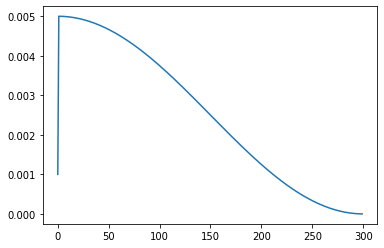

In [ ]:
start_lr = 0.005
alpha = 0.0001
decay_steps = epochs

def lr_scheduler(epoch, start_lr):
    if epoch < 1:
      lr = (start_lr-0.001)/1*epoch+0.001
    else:
      cosine_decay = 0.5 * (1 + tf.cos(np.pi * epoch / (decay_steps)))
      decayed = (1 - alpha) * cosine_decay + alpha
      lr = start_lr * decayed
    return lr

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_scheduler(epoch, start_lr), verbose=1)

#Plot learning rate

x_range = np.arange(epochs)
y = [lr_scheduler(x, start_lr) for x in x_range]
plt.plot(x_range, y)
print('Learning rate per epoch:')

Create and compile the model.

In [ ]:
#Set network_name
network_name = 'regression_model_final'

base_model = EfficientNetLiteB0mod(input_shape=(target_image_size, target_image_size, 150),weights=None)
model = tf.keras.Sequential([base_model,  
                             layers.Flatten(),
                                 layers.Dense(4, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=1509))])

def custom_metric(y_true, y_pred):
    y_true = tf.multiply(y_true, max_gt_values)
    y_pred = tf.multiply(y_pred, max_gt_values)
    mse = tf.reduce_mean((y_true-y_pred)**2, axis=0)
    score = tf.reduce_mean(mse/mse_baseline)

    return score

opt = keras.optimizers.Adam(clipnorm=1.)
model.compile(
    optimizer=opt,
    loss='mse',
    metrics=[custom_metric],
  )

model.summary()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:198: UserWarning: This model usually expects 1 or 3 input channels. However, it was passed an input_shape with 150 input channels.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetlite0 (Function  (None, 1, 1, 1280)       728896    
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 734,020
Trainable params: 719,780
Non-trainable params: 14,240
_________________________________________________________________


Define saving paths.

In [ ]:
base_path = '/content/'

checkpoint_filepath = base_path + network_name + '/checkpoint'
submission_name = 'sumbission_' + network_name + '.csv'

print(checkpoint_filepath)

/content/regression_model_final/checkpoint


Train the model.

In [ ]:
# Train model
History = model.fit(train_data, epochs=epochs, callbacks=[lr_callback], validation_data=val_data)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/300
54/54 [==============================] - 182s 2s/step - loss: 0.4071 - custom_metric: 370.5764 - val_loss: 0.0848 - val_custom_metric: 59.0755 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.004999862983822823.
Epoch 2/300
54/54 [==============================] - 3s 60ms/step - loss: 0.2893 - custom_metric: 272.2738 - val_loss: 0.0414 - val_custom_metric: 17.9325 - lr: 0.0050

Epoch 3: LearningRateScheduler setting learning rate to 0.0049994513392448425.
Epoch 3/300
54/54 [==============================] - 3s 62ms/step - loss: 0.0356 - custom_metric: 25.0978 - val_loss: 0.0091 - val_custom_metric: 4.1704 - lr: 0.0050

Epoch 4: LearningRateScheduler setting learning rate to 0.0049987658858299255.
Epoch 4/300
54/54 [==============================] - 3s 62ms/step - loss: 0.0306 - custom_metric: 23.1114 - val_loss: 0.0122 - val_custom_metric: 5.1166 - lr: 0.0050

Epoch 5: LearningRateSchedul

Export trained model.

In [ ]:
model.save(checkpoint_filepath)

INFO:tensorflow:Assets written to: /content/regression_model_final/checkpoint/assets


# Load model and make predictions

Define test set preprocessing functions.

In [ ]:
def normalize_test(image, height, width, max_reflectance_overall):             #Function to normalize the test dataset
    image = tf.cast(image,tf.float32)
    image = image/(max_reflectance_overall)

    return image, height, width

def image_repetition_test(image, height, width):    #Function that repeats small images to create a bigger image
    nx = tf.math.floordiv(target_image_size, tf.cast(width, tf.int32))
    ny = tf.math.floordiv(target_image_size, tf.cast(height, tf.int32))
    
    image = tf.tile(image, [ny, nx, 1])
    image = tf.cond(tf.math.maximum(nx, ny)==1, lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False), lambda: tf.image.pad_to_bounding_box(image, 0, 0, target_image_size, target_image_size))

    return image

def pad_with_patches_test(image, height, width):    #Function to resize images 
    max_dim = tf.math.maximum(height, width)
    image = tf.cond(max_dim<target_image_size, lambda: image_repetition_test(image, height, width), lambda: tf.image.resize(image, [target_image_size, target_image_size], method='bilinear', antialias=False))

    return image

Preprocessing of test dataset.

In [ ]:
test_data = load_tf_records_test(test_tf_records_path).map(decode_dataset_test, num_parallel_calls=AUTO)

test_data = test_data.map(lambda image, height, width: normalize_test(image, height, width, max_reflectance_overall), num_parallel_calls=AUTO)    #normalize test dataset
test_data = test_data.map(lambda image, height, width: pad_with_patches_test(image, height, width), num_parallel_calls=AUTO).cache()    #pad test dataset
test_data = test_data.batch(batch_size=batch_size, drop_remainder=False).prefetch(AUTO)    #batch and prefetch test dataset

Load the exported model.

In [ ]:
loaded_model = keras.models.load_model(checkpoint_filepath, custom_objects={'custom_metric': custom_metric})

loaded_model.summary()

Make predictions and generate submission file.

In [ ]:
predictions = loaded_model.predict(test_data)
predictions *= max_gt_values

submission = pd.DataFrame(data=predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv(submission_name, index_label="sample_index")